### Student names: Anh Ha, Dat Nguyen, Phuong Nguyen

From the shopping list, using at least two different methods, create a weighted network for each method, using the support threshold as weight.

Find the communities for each network. Comment about the results with respect to the different thresholds and methods. How does it compare with the same analysis using 1-NN?



### Näive method to create a weighted network with s = 200

In [1]:
# reading csv file and load all items in all baskets (each line is a basket)
with open("groceries.csv", "rt", encoding='latin1') as f:
    basket = []
    i = 0
    for line in f:
        line = line.replace("\n","")
        items = line.split(",")
        basket.append(items)
    print(len(basket))
# printing first 10 baskets
for i in basket[:10]:
    print(i)

9835
['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']
['tropical fruit', 'yogurt', 'coffee']
['whole milk']
['pip fruit', 'yogurt', 'cream cheese', 'meat spreads']
['other vegetables', 'whole milk', 'condensed milk', 'long life bakery product']
['whole milk', 'butter', 'yogurt', 'rice', 'abrasive cleaner']
['rolls/buns']
['other vegetables', 'UHT-milk', 'rolls/buns', 'bottled beer', 'liquor (appetizer)']
['potted plants']
['whole milk', 'cereals']


In [2]:
import itertools

def readdata(k, fname="groceries.csv", report=True):
    C_k = []
    b = 0
    
    with open("groceries.csv", "rt", encoding='latin1') as f:
        lines = f.readlines()
        for line in lines:
            line = line.replace('\n', '')  # remove newline symbol
            for i in line.split(','):
                C_k.append(i)
        
            # end of basket, report all itemsets
            for itemset in itertools.combinations(C_k, k):
                yield frozenset(itemset)
            C_k = []
                
            # report progress
            # print every 1000th element to reduce clutter
            if report:
                if b % 5000 == 0 and b > 0:  
                    print('processing bin ', b)
                b += 1 

In [3]:
import time

def naive_method(k,s):
    t = time.time()
    C = {}
    for key in readdata(k,report=False):
        if key not in C:
            C[key] = 1
        else:
            C[key] += 1
            
    print("{} initial itemsets to be filtered".format(len(C)))
    
    
    L = {}
    count = []
    for key, n in C.items():
        if n >= s:
            L[key] = n
            count.append(n)
    t1 = time.time() - t
    print('Naive method took {} seconds'.format(t1))
    print('{} candidates with >{} occurances'.format(len(L), s))
    print('')
    return L, count

In [4]:
import numpy as np

data_array = naive_method(2,200)
nodes = data_array[0]
count = data_array[1]

data = list(map(list, nodes))

a = 0
for i in data:
    i.append(int(count[a]))
    a+=1

data = np.array(data)
print(data[:10])
print(type(data))

9636 initial itemsets to be filtered
Naive method took 0.20036005973815918 seconds
60 candidates with >200 occurances

[['yogurt' 'tropical fruit' '288']
 ['whole milk' 'other vegetables' '736']
 ['butter' 'whole milk' '271']
 ['yogurt' 'whole milk' '551']
 ['rolls/buns' 'other vegetables' '419']
 ['tropical fruit' 'other vegetables' '353']
 ['bottled water' 'other vegetables' '244']
 ['citrus fruit' 'whole milk' '300']
 ['yogurt' 'citrus fruit' '213']
 ['whole milk' 'tropical fruit' '416']]
<class 'numpy.ndarray'>


In [5]:
long_list = []
for i in data[:,:2]:
    for y in i:
        long_list.append(y)

single_item = np.unique(long_list)


In [6]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import itertools

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 6]

In [8]:
# make the graph
w1 = 200    # threshold's weight 

G = nx.Graph()
for i in single_item:
    G.add_node(i)
 
    for n1, n2, w in data:
        if int(w) >= w1:
            G.add_edge(n1, n2, weight = w)

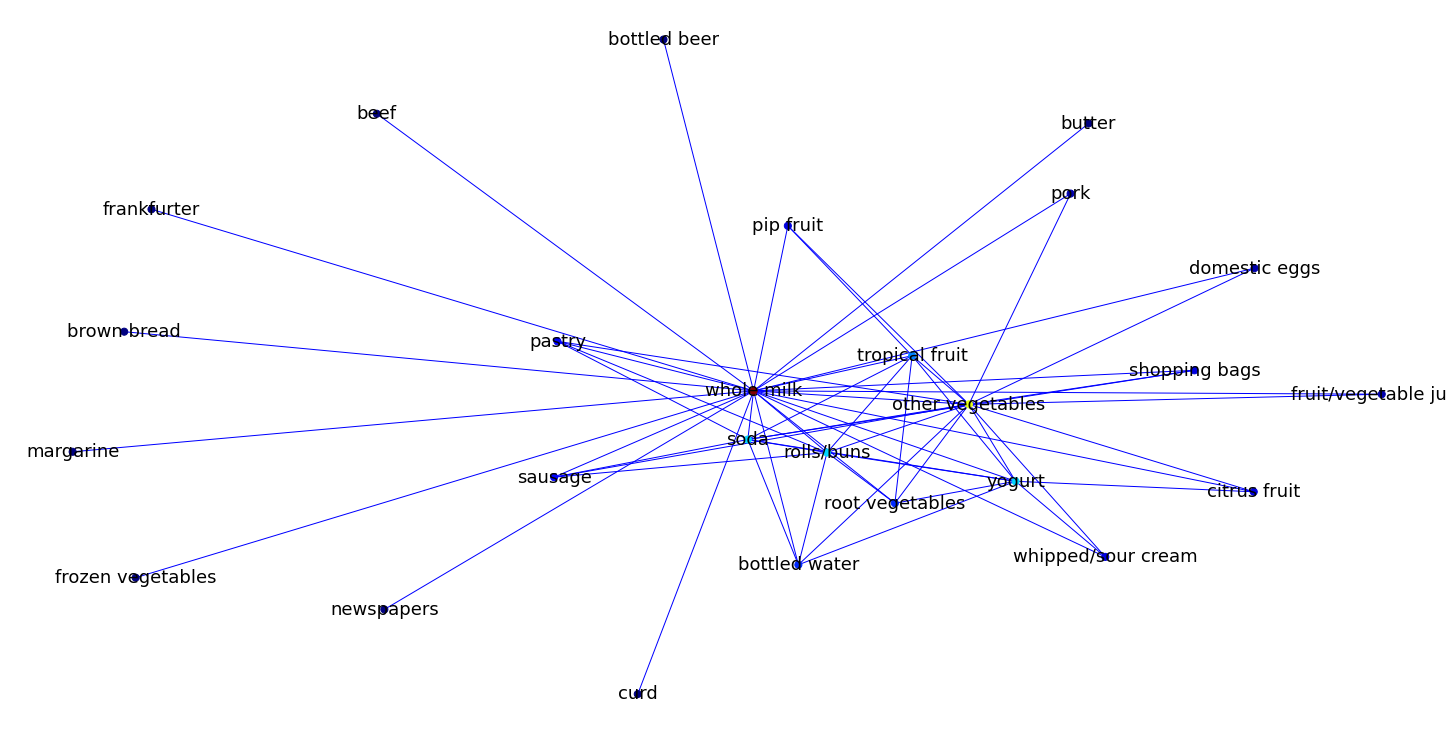

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 10]

# show graph
node_degrees_1 = nx.degree(G)
node_degrees = list(dict(node_degrees_1).values())
nx.draw(G, node_size=50, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees, with_labels =True, font_size = 18)
plt.show()

In [10]:
len(G.nodes), len(G.edges)

(26, 60)

### Comments: 
1. Based on nodes degree, we can see the important nodes are  in order whole milk, other vegetables, yogurt/soda/rolls/buns, tropical fruit, and so on.  
2. We already run with s= 50 , 100, but it is too difficult to observe, that why we chosed s=200 to create a clearer weighted network. 

### Communities for Näive method (s=200)

In [11]:
len(G.nodes), len(G.edges)

(26, 60)

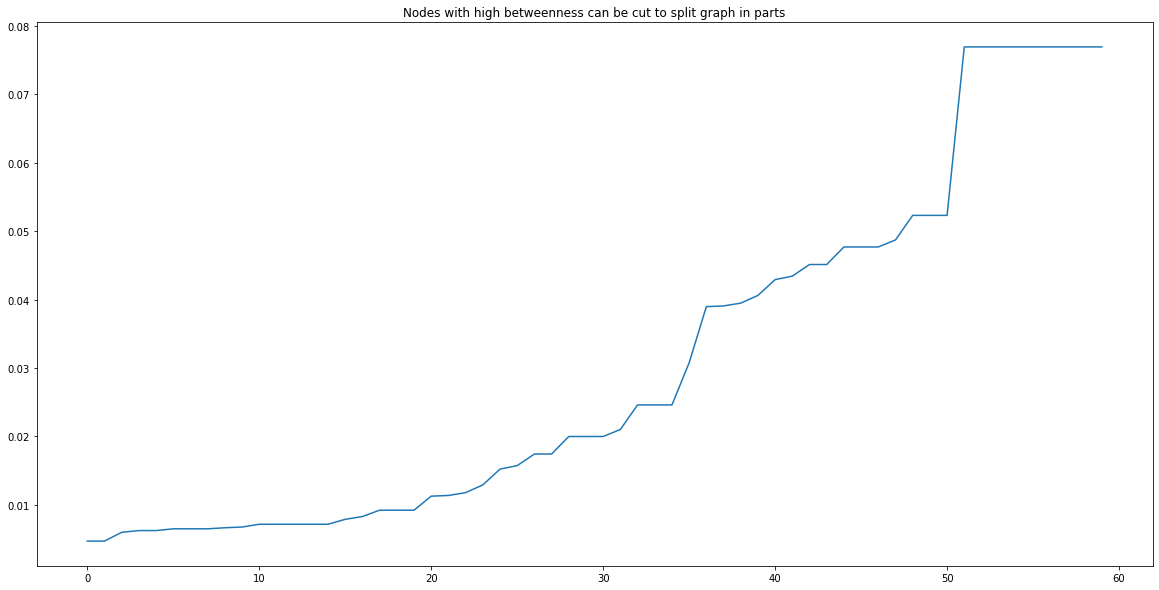

In [12]:
#from networkx import edge_betweenness_centrality as betweenness

# print betweenness
bt = list(nx.edge_betweenness(G).values())
plt.plot(range(len(bt)), sorted(bt))
plt.title("Nodes with high betweenness can be cut to split graph in parts")

plt.show()


In [13]:
# remove edges with betweenness larger than threshold
thr = 0.015
while True:
    bt = nx.edge_betweenness(G)
    
    i = np.argmax(list(bt.values()))
    if list(bt.values())[i] < thr:
        break
    n1, n2 = list(bt.keys())[i]
    G.remove_edge(n1, n2)

# clean graph from single-node components for easy printing
for n, d in list(nx.degree(G)):
    if d == 0:
        G.remove_node(n)

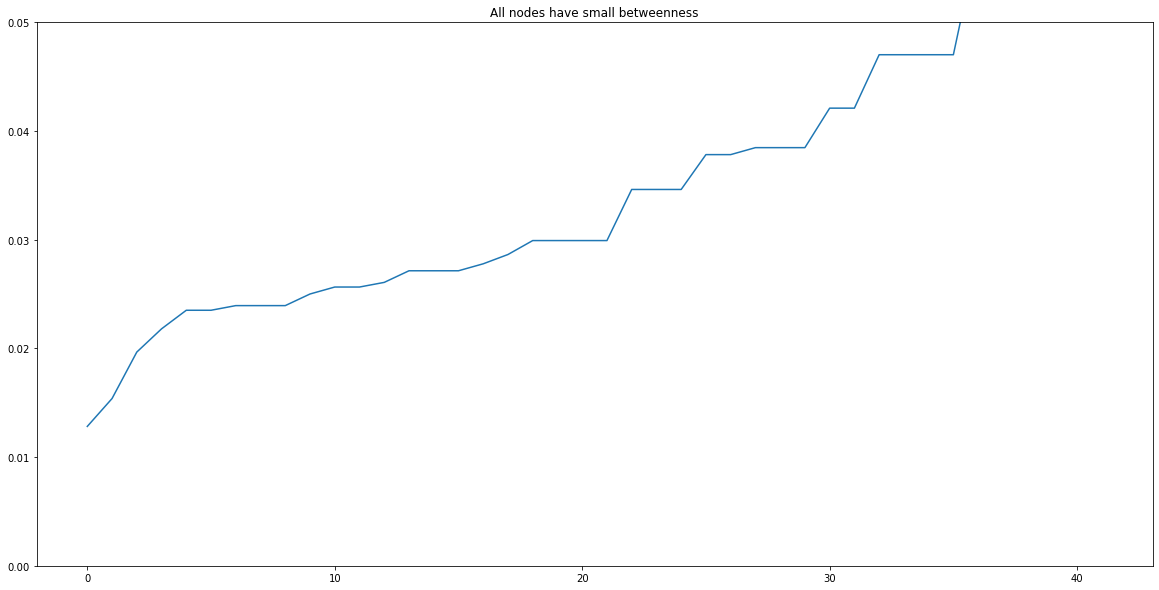

In [14]:
bt = nx.edge_betweenness(G).values()
plt.plot(range(len(bt)), sorted(bt))
plt.title("All nodes have small betweenness")
plt.ylim([0, 0.05])
plt.show()

In [15]:
print(nx.__version__)

2.4


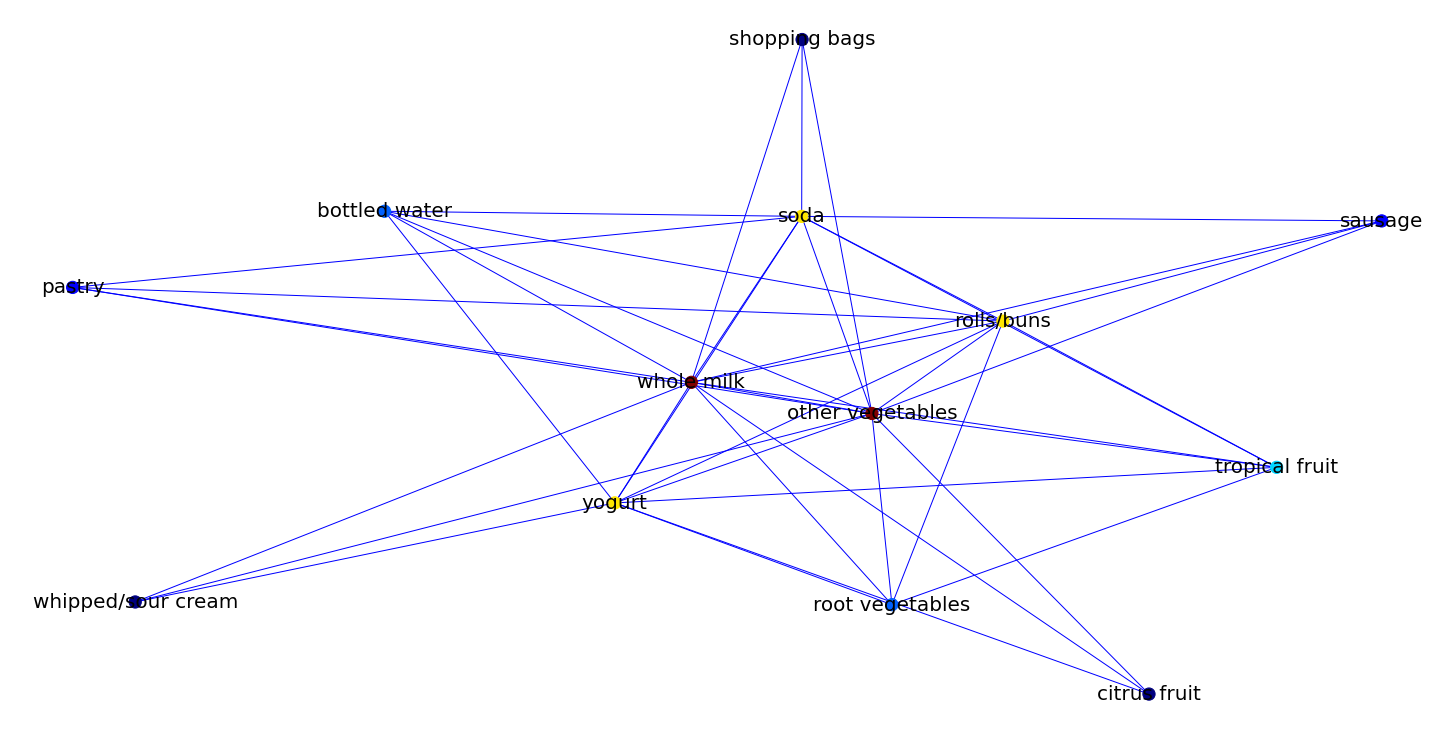

In [16]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
# print found components
#for G1 in nx.connected_component_subgraphs(G):  # for nx < 2.4 version
for G1 in connected_component_subgraphs(G): # for nx >= 2.4 version
    node_degrees = list(dict(nx.degree(G1)).values())
    nx.draw(G1, node_size=150, font_size = 20, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees, with_labels = True)
    plt.show()

In [17]:
len(G.nodes), len(G.edges)

(13, 42)

In [18]:
from networkx.algorithms.community.centrality import girvan_newman
from operator import itemgetter
from time import sleep
from networkx import edge_betweenness_centrality as betweenness

def heaviest(G):
    u, v, w = max(G.edges(data='weight'), key=itemgetter(2))
    return (u, v)

In [19]:
# getting the weights
comp_b = betweenness(G,normalized=False)

print(comp_b)

# New graph
Gw = nx.Graph()


for a,b in zip(comp_b.keys(),comp_b.values()):
        Gw.add_edge(a[0], a[1], weight=b)

k = 10

print(list(Gw.nodes))
print('Cluster')
comp_gn = girvan_newman(Gw, most_valuable_edge=heaviest)
for communities in itertools.islice(comp_gn, k):
    sleep(2)
    print(tuple(sorted(c) for c in communities))

{('yogurt', 'tropical fruit'): 1.866666666666667, ('yogurt', 'whole milk'): 1.8333333333333333, ('yogurt', 'citrus fruit'): 2.9999999999999996, ('yogurt', 'bottled water'): 2.1166666666666667, ('yogurt', 'root vegetables'): 2.1166666666666667, ('yogurt', 'soda'): 2.6999999999999997, ('yogurt', 'rolls/buns'): 2.1666666666666665, ('yogurt', 'other vegetables'): 1.8333333333333333, ('yogurt', 'whipped/sour cream'): 3.0, ('tropical fruit', 'other vegetables'): 2.6999999999999997, ('tropical fruit', 'whole milk'): 2.6999999999999997, ('tropical fruit', 'root vegetables'): 1.2, ('tropical fruit', 'rolls/buns'): 1.7000000000000002, ('tropical fruit', 'soda'): 2.2333333333333334, ('whole milk', 'other vegetables'): 1.0, ('whole milk', 'citrus fruit'): 4.5, ('whole milk', 'bottled water'): 2.9499999999999993, ('whole milk', 'root vegetables'): 3.2833333333333328, ('whole milk', 'whipped/sour cream'): 4.5, ('whole milk', 'soda'): 1.866666666666667, ('whole milk', 'pastry'): 3.666666666666667, ('

In [20]:
list(nx.connected_components(G))
sorted(d for n, d in G.degree())
nx.clustering(G)

{'yogurt': 0.6111111111111112,
 'tropical fruit': 0.9333333333333333,
 'whole milk': 0.45454545454545453,
 'other vegetables': 0.45454545454545453,
 'rolls/buns': 0.6666666666666666,
 'bottled water': 1.0,
 'citrus fruit': 1.0,
 'soda': 0.6111111111111112,
 'root vegetables': 1.0,
 'sausage': 1.0,
 'shopping bags': 1.0,
 'whipped/sour cream': 1.0,
 'pastry': 1.0}

### Comments: 
1. The network contained all nodes in a connected relationship, it can not detect communities separately by subgraphs. 
2. However, based on Girvan_Newman results, it is possible to identify a cluster like ['whipped/sour cream'] and another cluster like 
['bottled water', 'citrus fruit', 'other vegetables', 'pastry', 'rolls/buns', 'root vegetables', 'sausage', 'shopping bags', 'soda', 'tropical fruit', 'whole milk', 'yogurt'] 
based on nodes degree. 


### 1-nn method 

In [21]:
cluster2 = list(naive_method(2,200))
cluster2[0]

9636 initial itemsets to be filtered
Naive method took 0.2588512897491455 seconds
60 candidates with >200 occurances



{frozenset({'tropical fruit', 'yogurt'}): 288,
 frozenset({'other vegetables', 'whole milk'}): 736,
 frozenset({'butter', 'whole milk'}): 271,
 frozenset({'whole milk', 'yogurt'}): 551,
 frozenset({'other vegetables', 'rolls/buns'}): 419,
 frozenset({'other vegetables', 'tropical fruit'}): 353,
 frozenset({'bottled water', 'other vegetables'}): 244,
 frozenset({'citrus fruit', 'whole milk'}): 300,
 frozenset({'citrus fruit', 'yogurt'}): 213,
 frozenset({'tropical fruit', 'whole milk'}): 416,
 frozenset({'curd', 'whole milk'}): 257,
 frozenset({'bottled water', 'whole milk'}): 338,
 frozenset({'bottled water', 'yogurt'}): 226,
 frozenset({'rolls/buns', 'soda'}): 377,
 frozenset({'root vegetables', 'tropical fruit'}): 207,
 frozenset({'rolls/buns', 'tropical fruit'}): 242,
 frozenset({'other vegetables', 'root vegetables'}): 466,
 frozenset({'rolls/buns', 'root vegetables'}): 239,
 frozenset({'rolls/buns', 'sausage'}): 301,
 frozenset({'sausage', 'soda'}): 239,
 frozenset({'shopping bags

In [22]:
P2 = list(map(list, cluster2[0])) 
print(P2)

[['yogurt', 'tropical fruit'], ['whole milk', 'other vegetables'], ['butter', 'whole milk'], ['yogurt', 'whole milk'], ['rolls/buns', 'other vegetables'], ['tropical fruit', 'other vegetables'], ['bottled water', 'other vegetables'], ['citrus fruit', 'whole milk'], ['yogurt', 'citrus fruit'], ['whole milk', 'tropical fruit'], ['curd', 'whole milk'], ['bottled water', 'whole milk'], ['bottled water', 'yogurt'], ['rolls/buns', 'soda'], ['root vegetables', 'tropical fruit'], ['rolls/buns', 'tropical fruit'], ['root vegetables', 'other vegetables'], ['root vegetables', 'rolls/buns'], ['sausage', 'rolls/buns'], ['sausage', 'soda'], ['shopping bags', 'soda'], ['bottled water', 'rolls/buns'], ['root vegetables', 'whole milk'], ['other vegetables', 'pork'], ['whole milk', 'pork'], ['whipped/sour cream', 'other vegetables'], ['soda', 'other vegetables'], ['whipped/sour cream', 'whole milk'], ['whole milk', 'soda'], ['soda', 'pastry'], ['tropical fruit', 'soda'], ['yogurt', 'root vegetables'], [

In [23]:
l = list(P2)

result = []
if len(l) > 1:
  tmp = [l[0]]
  for i in range(1,len(l)):
    if l[i][0] == l[i-1][1] or l[i][1] == l[i-1][0] or l[i][1] == l[i-1][1] or l[i][0] == l[i-1][0]:
      tmp.append(l[i])
    else:
      result.append(tmp)
      tmp = [l[i]]
  result.append(tmp)
else:
  result = l

for elem in result:
  print(elem)

[['yogurt', 'tropical fruit']]
[['whole milk', 'other vegetables'], ['butter', 'whole milk'], ['yogurt', 'whole milk']]
[['rolls/buns', 'other vegetables'], ['tropical fruit', 'other vegetables'], ['bottled water', 'other vegetables']]
[['citrus fruit', 'whole milk'], ['yogurt', 'citrus fruit']]
[['whole milk', 'tropical fruit'], ['curd', 'whole milk'], ['bottled water', 'whole milk'], ['bottled water', 'yogurt']]
[['rolls/buns', 'soda']]
[['root vegetables', 'tropical fruit'], ['rolls/buns', 'tropical fruit']]
[['root vegetables', 'other vegetables'], ['root vegetables', 'rolls/buns'], ['sausage', 'rolls/buns'], ['sausage', 'soda'], ['shopping bags', 'soda']]
[['bottled water', 'rolls/buns']]
[['root vegetables', 'whole milk']]
[['other vegetables', 'pork'], ['whole milk', 'pork']]
[['whipped/sour cream', 'other vegetables'], ['soda', 'other vegetables']]
[['whipped/sour cream', 'whole milk'], ['whole milk', 'soda'], ['soda', 'pastry'], ['tropical fruit', 'soda']]
[['yogurt', 'root ve

In [24]:
print(len(result))

24


### Comments: 
With 1-nn method we can find more neighbor clusters than with graph mining by using networkx 

### Apriori method to create a weighted network with s =200

In [25]:
def apriori(s):
    t = time.time()
    C1 = {}
    for key in readdata(1, report=False):
        if key not in C1:
            C1[key] = 1
        else:
            C1[key] += 1
    
    
    L1 = {}
    for key, count in C1.items():
        if count >= s:
            L1[key] = count
    
    
    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()])
    C2 = {}
    for key in readdata(2, report=False):
        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1
    
            
    print("{} initial itemsets to be filtered".format(len(C2)))
    
    
    L2 = {}
    amount = []
    for key, count in C2.items():
        if count >= s:
            L2[key] = count
            amount.append(count)
    
    t1 = time.time() - t
    
         
    print('Apriori algorithm took {} seconds'.format(t1))
    print('{} candidates with >{} occurances'.format(len(L2), s))
    print('')
    return L2, amount

In [26]:
apriori(200)


1711 initial itemsets to be filtered
Apriori algorithm took 0.2794814109802246 seconds
60 candidates with >200 occurances



({frozenset({'tropical fruit', 'yogurt'}): 288,
  frozenset({'other vegetables', 'whole milk'}): 736,
  frozenset({'butter', 'whole milk'}): 271,
  frozenset({'whole milk', 'yogurt'}): 551,
  frozenset({'other vegetables', 'rolls/buns'}): 419,
  frozenset({'other vegetables', 'tropical fruit'}): 353,
  frozenset({'bottled water', 'other vegetables'}): 244,
  frozenset({'citrus fruit', 'whole milk'}): 300,
  frozenset({'citrus fruit', 'yogurt'}): 213,
  frozenset({'tropical fruit', 'whole milk'}): 416,
  frozenset({'curd', 'whole milk'}): 257,
  frozenset({'bottled water', 'whole milk'}): 338,
  frozenset({'bottled water', 'yogurt'}): 226,
  frozenset({'rolls/buns', 'soda'}): 377,
  frozenset({'root vegetables', 'tropical fruit'}): 207,
  frozenset({'rolls/buns', 'tropical fruit'}): 242,
  frozenset({'other vegetables', 'root vegetables'}): 466,
  frozenset({'rolls/buns', 'root vegetables'}): 239,
  frozenset({'rolls/buns', 'sausage'}): 301,
  frozenset({'sausage', 'soda'}): 239,
  froz

In [27]:
data_array1 = apriori(200)
nodes1 = data_array1[0]
count1 = data_array1[1]

data1 = list(map(list, nodes1))

a = 0
for i in data1:
    i.append(int(count1[a]))
    a+=1

data1 = np.array(data1)
print(data1[:10])
print(type(data1))

1711 initial itemsets to be filtered
Apriori algorithm took 0.4017670154571533 seconds
60 candidates with >200 occurances

[['yogurt' 'tropical fruit' '288']
 ['whole milk' 'other vegetables' '736']
 ['butter' 'whole milk' '271']
 ['yogurt' 'whole milk' '551']
 ['rolls/buns' 'other vegetables' '419']
 ['tropical fruit' 'other vegetables' '353']
 ['bottled water' 'other vegetables' '244']
 ['citrus fruit' 'whole milk' '300']
 ['yogurt' 'citrus fruit' '213']
 ['whole milk' 'tropical fruit' '416']]
<class 'numpy.ndarray'>


In [28]:
long_list1 = []
for i in data1[:,:2]:
    for y in i:
        long_list1.append(y)

single_item1 = np.unique(long_list1)


In [29]:
# make the graph
w2 = 200    # threshold's weight 

G1 = nx.Graph()
for i in single_item1:
    G1.add_node(i)
 
    for n1, n2, w in data1:
        if int(w) >= w2:
            G1.add_edge(n1, n2, weight = w)

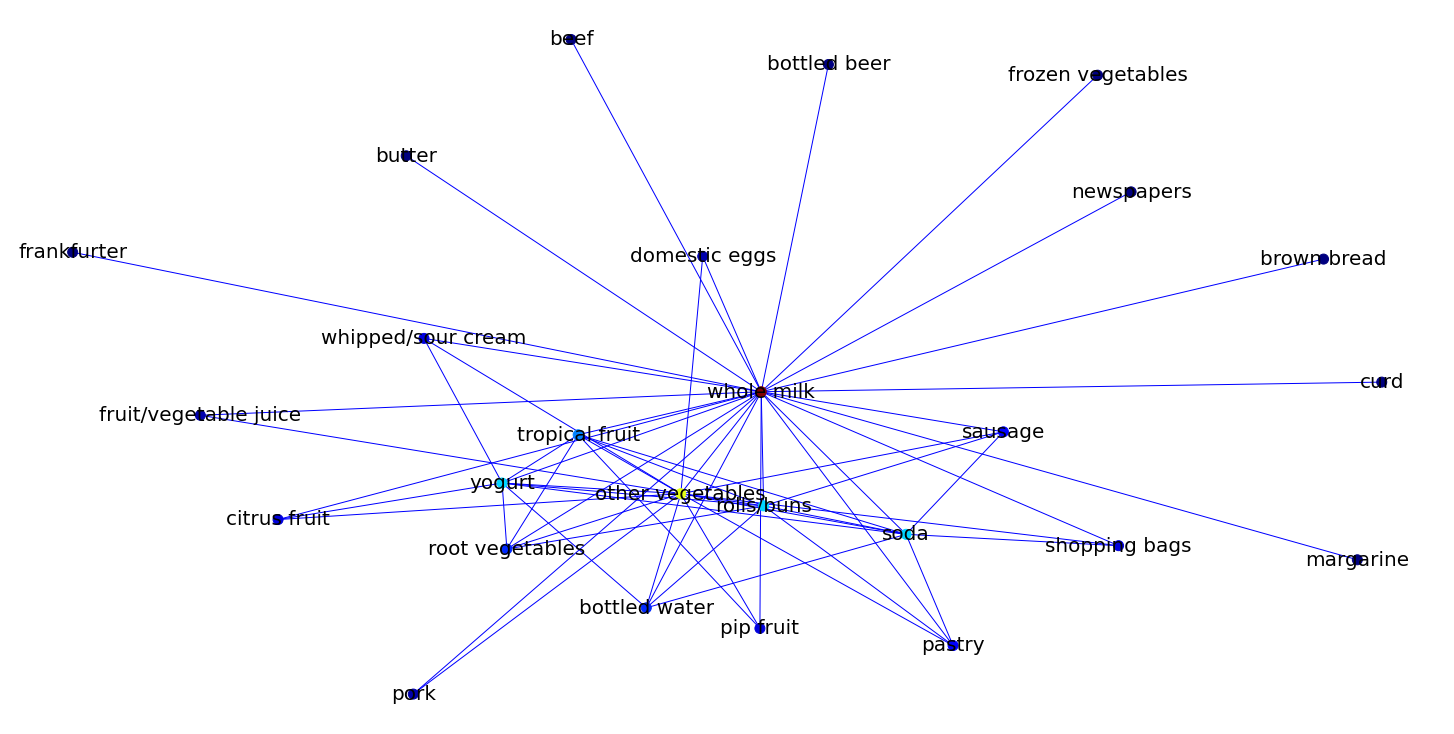

In [30]:
# show graph
node_degrees_1a = nx.degree(G1)
node_degrees1 = list(dict(node_degrees_1a).values())
nx.draw(G1, node_size=100, font_size = 20, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees1, with_labels =True)
plt.show()

In [31]:
len(G1.nodes), len(G1.edges)

(26, 60)

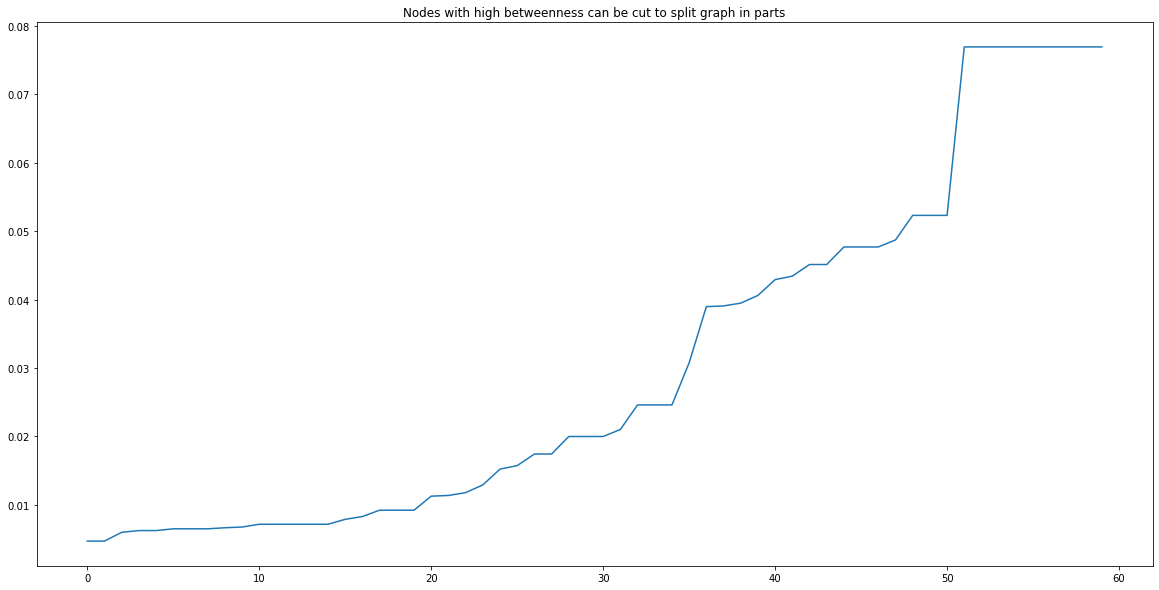

In [32]:
#from networkx import edge_betweenness_centrality as betweenness

# print betweenness
bt = list(nx.edge_betweenness(G1).values())
plt.plot(range(len(bt)), sorted(bt))
plt.title("Nodes with high betweenness can be cut to split graph in parts")

plt.show()

In [33]:
# remove edges with betweenness larger than threshold
thr = 0.015
while True:
    bt = nx.edge_betweenness(G1)
    
    i = np.argmax(list(bt.values()))
    if list(bt.values())[i] < thr:
        break
    n1, n2 = list(bt.keys())[i]
    G1.remove_edge(n1, n2)

# clean graph from single-node components for easy printing
for n, d in list(nx.degree(G1)):
    if d == 0:
        G1.remove_node(n)

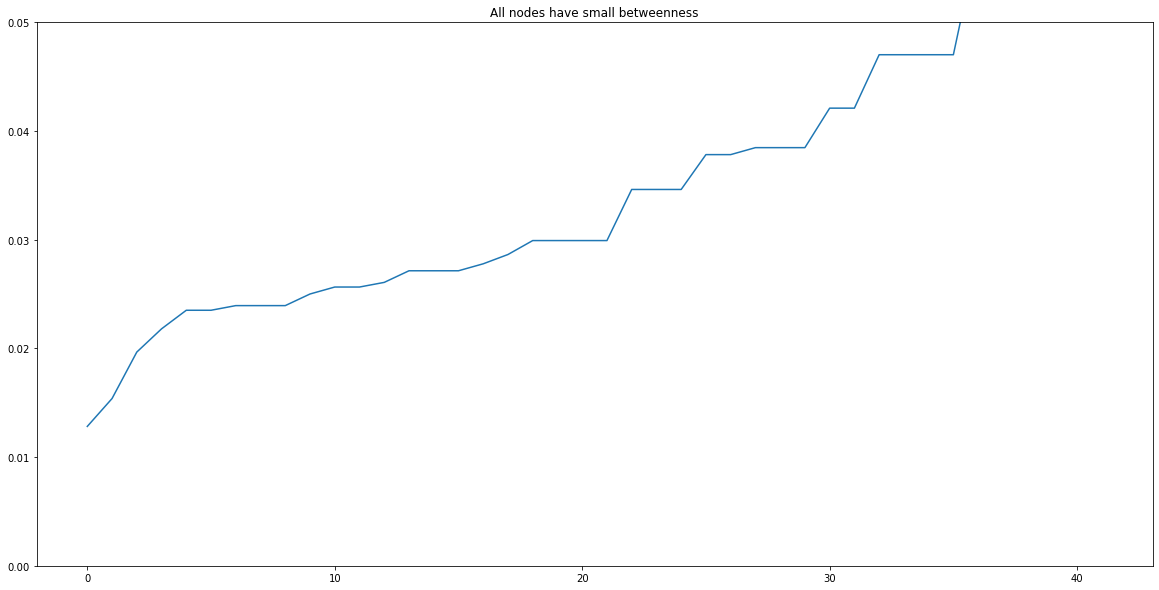

In [34]:
bt = nx.edge_betweenness(G1).values()
plt.plot(range(len(bt)), sorted(bt))
plt.title("All nodes have small betweenness")
plt.ylim([0, 0.05])
plt.show()

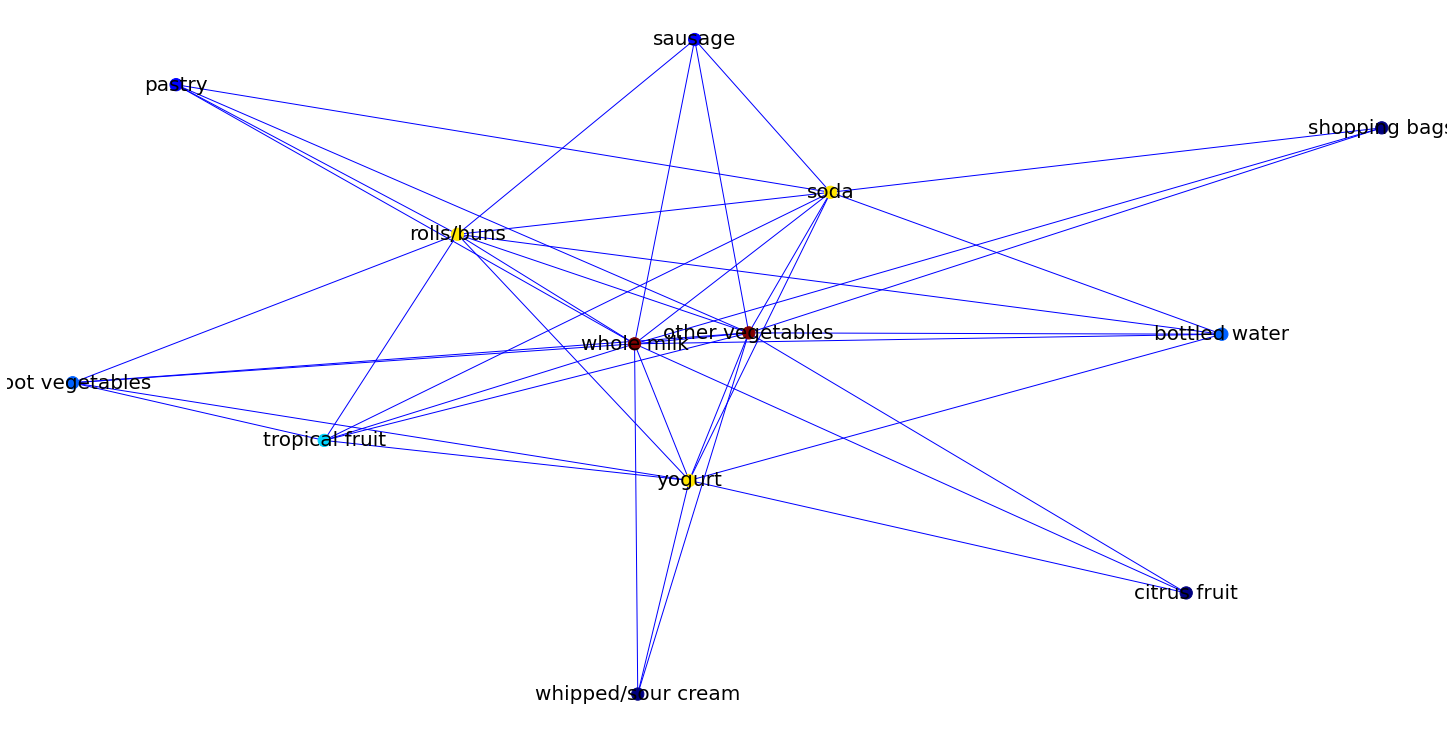

In [35]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
# print found components

for G2 in connected_component_subgraphs(G1): # for nx >= 2.4 version
    node_degrees = list(dict(nx.degree(G2)).values())
    nx.draw(G2, node_size=150, font_size = 20, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees, with_labels = True)
    plt.show()

In [36]:
len(G1.nodes), len(G1.edges)

(13, 42)

### Comments: 
1. Apriori method can create a weighted network same as Näive method (pair-wise).
2. According to subgraphs, the community found by Apriori method is the same as the network built by Näive method, after removing small nodes degree and high betweeness edges. 

### Members contribution: we have worked collaborately and equally. 